In [1]:
import pandas as pd
import numpy as np
import re
#import math
#from random import choices
#import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
#import statistics

In [2]:
import devanalyst.simulation.statics as S_

from devanalyst.simulation.businessObjects import WorkAssignments, ReleaseCycleContext, Ticket
from devanalyst.simulation.simulationModels import BalancedAllocationModel, GreedyAllocationModel, ModelsConfig, \
Distribution, DefaultCostModel, QualityModel

import devanalyst.simulation.generateTimecards as timecard
#from devanalyst.simulation.generateTimecards import WorkAssignments


importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\statics.ipynb
importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\businessObjects.ipynb
importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\simulationModels.ipynb
importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\generateTimecards.ipynb


In [3]:
import devanalyst.simulation.tests.test_utils as tu_

importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\tests\test_utils.ipynb


In [4]:
import devanalyst.simulation.visualizations.simm_visuals as simm_visuals
import devanalyst.simulation.visualizations.timecard_visuals as tc_visuals

importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\visualizations\simm_visuals.ipynb
importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\visualizations\timecard_visuals.ipynb


<h1>Pilots</h1>

<h2>Bug inflow prototypes</h2>

In [5]:
class DistributedLagQualityModel(QualityModel):

    def __init__(self):
        super(DistributedLagQualityModel, self).__init__()
        return
    
    # Returns a list of Ticket instances.
    # -modelsConfig: a ModelsConfig instance
    def findBugs(self, modelsConfig): 
        uss_list = DistributedLagQualityModel._findFinishedStories(modelsConfig.context)
        
        bugs = []
        current_sprint = modelsConfig.context.sprint
        for uss in uss_list:
            delivery_sprint = uss.sprintDelivered
            lag = current_sprint - delivery_sprint
            story = modelsConfig.context.storiesRepo.findStory(uss.userStoryId)
            story_bugs = DistributedLagQualityModel._findDefectsInStory(lag, story, uss, modelsConfig)
            bugs.extend(story_bugs)
        return bugs

    # Returns a list of UserStoryStatus instances, corresponding to all user stories that have been finished.
    def _findFinishedStories(context):
        uss_list = []
        ids = context.storiesRepo.findIds()
        for userStoryId in ids:
            teamId = context.teamsRepo.getTeamId(userStoryId)
            if (teamId != context.teamId):
                # We only want the finished stories owned by the context.teamId to avoid a bug whereby we generate 
                # bugs for the stories of another team, whilst still in the same sprint as the user story
                # that the bug is for, which is an assertion violation (since bugs should be found after
                # a story is delivered, not in the same sprint, as might happen if a different team Y who is closing
                # a sprint after another team X finds X's completed story and generates a bug for X's story
                # in the same sprint)
                continue 
            uss = context.teamsRepo.getUserStoryStatus(userStoryId)
            if (uss.percentAchieved == 1.0):
                uss_list.append(uss)
        return uss_list
    
    # Returns a list of Ticket instances
    def _findDefectsInStory(lag, userStory, uss, modelsConfig):
        if lag < 1 or lag > 3: # No bugs for stories just finished or which were finished a while ago
            return []
        # Exposure is the probability of finding a bug. For now hardcode a 50% exposure distributed over 
        # 3 sprints with the surge in the middle one
        if lag == 1:
            exposure = 0.125
        if lag == 2:
            exposure = 0.25
        if lag == 3:
            exposure = 0.125
        possible_defect_count  = [0, 1] # Possible values for number of bugs found
        likelihoods            = [1-exposure, exposure]
        defect_count           = modelsConfig.random.pickOneWithWeights(possible_defect_count, likelihoods)
        
        # Issue defect Tickets
        defects = []
        repo = modelsConfig.context.ticketsRepo
        for i in range(defect_count):
            costToFix = DistributedLagQualityModel._estimateCostToFix(userStory, modelsConfig)
            ticketId = repo._nextTicketId()
            ticket = Ticket(ticketId, userStory.userStoryId, costToFix, modelsConfig.context.sprint)
            repo.addTicket(ticket)
            defects.append(ticket)
        return defects
    
        
    def _estimateCostToFix(userStory, modelsConfig):
    # For now hard-code a simplistic cost to fix: each bug costs 20% of the original estimate of the story.
    # Better would be a percentage of the actual cost to develop.
         return 0.20 * userStory.originalEstimate


In [6]:
def testTicketInflow(modelsConfig):
    RELEASE_DURATION = 60
    SPRINT_DURATION = 10
    
    tu_.loadTestResources()
    
    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, \
                                                                                           tu_.PM_DF, \
                                                                                           RELEASE_DURATION, \
                                                                                           SPRINT_DURATION, \
                                                                                          modelsConfig)
    TEAM_ID = 'Team A'
    SPRINT = 1    
    ctx = ReleaseCycleContext(TEAM_ID, teamsRepo, storiesRepo, ticketsRepo, SPRINT, SPRINT_DURATION)
    modelsConfig.context = ctx

    # Pretend all stories have been completed on the first sprint
    uss_list = []
    ids = ctx.storiesRepo.findIds()
    for userStoryId in ids:
        uss = ctx.teamsRepo.getUserStoryStatus(userStoryId)
        uss.percentAchieved = 1.0
        uss.planned = True
        uss.sprintPlanned = 1
        uss.sprintDelivered = 1
    
    # Now pretend we raverse the next 5 sprints, generating bugs
    bugs = []
    for i in range(5):
        ctx.sprint = SPRINT + i + 1
        qualityModel = modelsConfig.qualityModels[0]
        bugs.extend(qualityModel.findBugs(modelsConfig))
    return bugs

In [7]:
def build_bugs_df(bugs):
    # -bugs: a list of Tickets
    bugs_dict = {}
    bugs_dict['Ticket Id']        = []
    bugs_dict['User Story Id']    = []
    bugs_dict['Estimated Cost']   = []
    bugs_dict['Effort to Date']   = []
    bugs_dict['Percent Achieved'] = []
    bugs_dict['Sprint Reported']  = []
    bugs_dict['Sprint Fixed']     = []
    
    for bug in bugs:
        bugs_dict['Ticket Id']        .append(bug.ticketId)
        bugs_dict['User Story Id']    .append(bug.userStoryId)
        bugs_dict['Estimated Cost']   .append(bug.estimatedCost)
        bugs_dict['Effort to Date']   .append(bug.effortToDate)
        bugs_dict['Percent Achieved'] .append(bug.percentAchieved)
        bugs_dict['Sprint Reported']  .append(bug.sprintReported)
        bugs_dict['Sprint Fixed']     .append(bug.sprintFixed)
        
    bugs_df = pd.DataFrame(bugs_dict)
    return bugs_df

In [8]:
def build_stories_df(modelsConfig):
# -modelsConfig
    stories_dict = {}
    cols = ['User Story Id', 'Original Estimate', 'Team Id', 'Developer', 'Product Manager', 'Percent Achieved', \
            'Planned', 'Sprint Planned', 'Sprint Delivered', 'Nb Open Bugs', 'Open Bugs', 'Nb Closed Bugs', 'Closed Bugs']
    for c in cols:
        stories_dict[c] = []
    
    storiesRepo    = modelsConfig.context.storiesRepo
    teamsRepo      = modelsConfig.context.teamsRepo
    ticketsRepo    = modelsConfig.context.ticketsRepo
    for storyId in storiesRepo.findIds():
        story        = storiesRepo.findStory(storyId)
        uss          = teamsRepo.getUserStoryStatus(storyId)
        open_bugs    = ticketsRepo.getOpenTickets(storyId)
        closed_bugs  = ticketsRepo.getClosedTickets(storyId)
        
        
        open_bugs_ids = []
        for bug in open_bugs:
            open_bugs_ids.append(bug.ticketId)
            
        closed_bugs_ids = []
        for bug in closed_bugs:
            closed_bugs_ids.append(bug.ticketId)

        
        stories_dict['User Story Id']       .append(story.userStoryId)
        stories_dict['Original Estimate']   .append(story.originalEstimate)
        stories_dict['Team Id']             .append(teamsRepo.getTeamId(storyId))
        stories_dict['Developer']           .append(story.developer)
        stories_dict['Product Manager']     .append(story.productManager)
        stories_dict['Percent Achieved']    .append(uss.percentAchieved)
        stories_dict['Planned']             .append(uss.planned)
        stories_dict['Sprint Planned']      .append(uss.sprintPlanned)
        stories_dict['Sprint Delivered']    .append(uss.sprintDelivered)        
        stories_dict['Nb Open Bugs']        .append(len(open_bugs_ids))   
        stories_dict['Open Bugs']           .append(open_bugs_ids)        
        stories_dict['Nb Closed Bugs']      .append(len(closed_bugs_ids))        
        stories_dict['Closed Bugs']         .append(closed_bugs_ids)        
        
    stories_df = pd.DataFrame(stories_dict)
    return stories_df

In [9]:
modelsConfig = ModelsConfig([DefaultCostModel(0.25)], [DistributedLagQualityModel()], GreedyAllocationModel()) 
modelsConfig.random.reset(271)
bugs = testTicketInflow(modelsConfig)
bugs_df = build_bugs_df(bugs)
bugs_df[:6]

,Ticket Id,User Story Id,Estimated Cost,Effort to Date,Percent Achieved,Sprint Reported,Sprint Fixed
0,Ticket #1,UserStory #3,0.8,0.0,0.0,2,NOT_SET
1,Ticket #2,UserStory #10,1.8,0.0,0.0,2,NOT_SET
2,Ticket #3,UserStory #15,0.6,0.0,0.0,2,NOT_SET
3,Ticket #4,UserStory #22,0.6,0.0,0.0,2,NOT_SET
4,Ticket #5,UserStory #30,0.4,0.0,0.0,2,NOT_SET
5,Ticket #6,UserStory #36,2.0,0.0,0.0,2,NOT_SET


In [10]:
bugs_df.shape

(42, 7)

In [11]:
bugs_df['Estimated Cost'].sum()

45.00000000000001

In [12]:
stories_df = build_stories_df(modelsConfig)
stories_a = stories_df[stories_df['Team Id'] == 'Team A']
stories_a

,User Story Id,Original Estimate,Team Id,Developer,Product Manager,Percent Achieved,Planned,Sprint Planned,Sprint Delivered,Nb Open Bugs,Open Bugs,Nb Closed Bugs,Closed Bugs
0,UserStory #1,10,Team A,Beau Hockensmith,Sherlyn Cordle,1.0,True,1,1,1,[Ticket #15],0,[]
1,UserStory #2,10,Team A,Glenna Mcghie,Sherlyn Cordle,1.0,True,1,1,0,[],0,[]
2,UserStory #3,4,Team A,Francisco Hoppe,Edgar Hibbler,1.0,True,1,1,1,[Ticket #1],0,[]
3,UserStory #4,7,Team A,Beau Hockensmith,Sherlyn Cordle,1.0,True,1,1,1,[Ticket #16],0,[]
4,UserStory #5,3,Team A,Gregorio Darr,Edgar Hibbler,1.0,True,1,1,1,[Ticket #17],0,[]
5,UserStory #6,3,Team A,Beau Hockensmith,Sherlyn Cordle,1.0,True,1,1,1,[Ticket #36],0,[]
6,UserStory #7,8,Team A,Anton Easterday,Sherlyn Cordle,1.0,True,1,1,0,[],0,[]
7,UserStory #8,9,Team A,Anton Easterday,Edgar Hibbler,1.0,True,1,1,0,[],0,[]
8,UserStory #9,9,Team A,Gregorio Darr,Sherlyn Cordle,1.0,True,1,1,0,[],0,[]
9,UserStory #10,9,Team A,Gregorio Darr,Sherlyn Cordle,1.0,True,1,1,1,[Ticket #2],0,[]


In [13]:
stories_a['Original Estimate'].sum()

440

In [14]:
stories_a.groupby('Nb Open Bugs').count()

,User Story Id,Original Estimate,Team Id,Developer,Product Manager,Percent Achieved,Planned,Sprint Planned,Sprint Delivered,Open Bugs,Nb Closed Bugs,Closed Bugs
Nb Open Bugs,,,,,,,,,,,,
0,43,43,43,43,43,43,43,43,43,43,43,43
1,34,34,34,34,34,34,34,34,34,34,34,34
2,4,4,4,4,4,4,4,4,4,4,4,4


In [15]:
def countUniques(seriesGroup):
    if (seriesGroup.unique()[0] == None):
        return 0
    else:
        return seriesGroup.unique().size

In [16]:
countUniques(bugs_df['User Story Id'])

38

In [17]:
bugs_df.shape

(42, 7)

In [18]:
modelsConfig.context.sprint

6

In [19]:
def genReleaseCycleSheets(modelsConfig):
    RELEASE_DURATION = 150
    SPRINT_DURATION = 10
    
    tu_.loadTestResources()
    
    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, \
                                                                                           tu_.PM_DF, \
                                                                                           RELEASE_DURATION, \
                                                                                           SPRINT_DURATION, \
                                                                                          modelsConfig)
    
    NUMBER_OF_SPRINTS = 25

    entries_df, releaseLog = timecard.runReleaseCycle(teamsRepo, ticketsRepo, storiesRepo, datetime(2018, 1, 15), \
                                                   SPRINT_DURATION, NUMBER_OF_SPRINTS, modelsConfig)    
    
    return entries_df, releaseLog, teamsRepo, storiesRepo

In [20]:
SPRINT_DURATION = 10
modelsConfig = ModelsConfig([DefaultCostModel(0.0)], [DistributedLagQualityModel()], GreedyAllocationModel()) 
modelsConfig.random.reset(271)
entries_df, releaseLog, TEAMS_REPO, STORIES_REPO = genReleaseCycleSheets(modelsConfig)

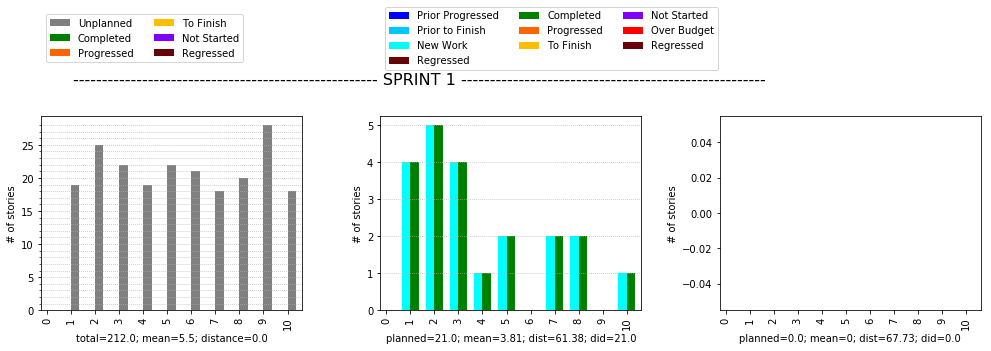

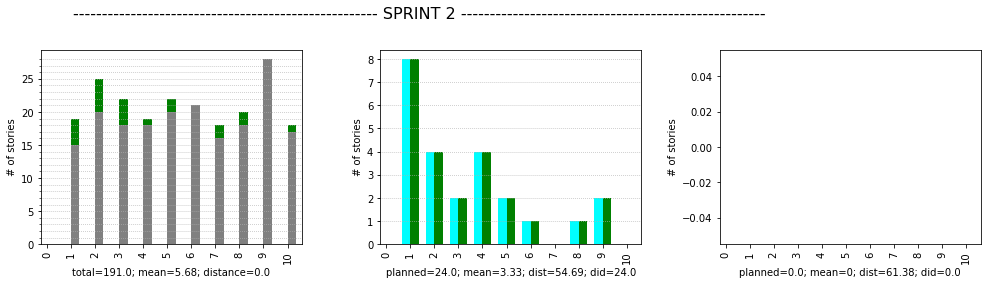

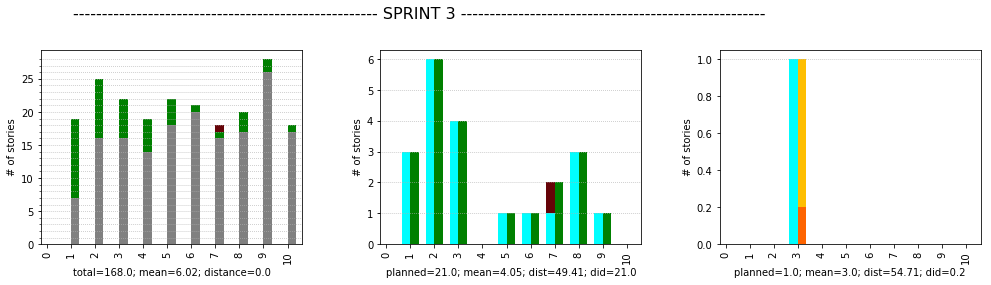

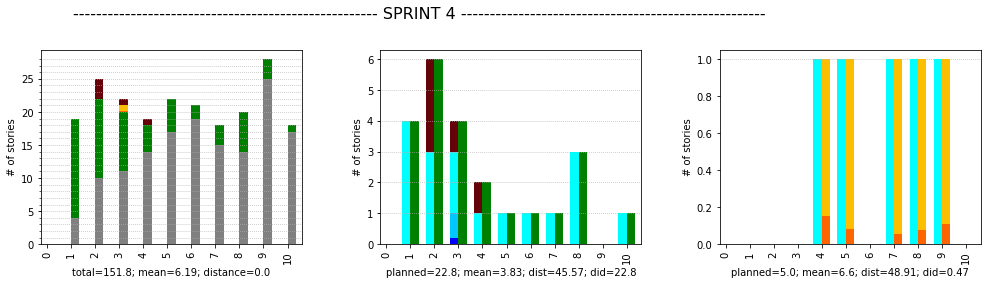

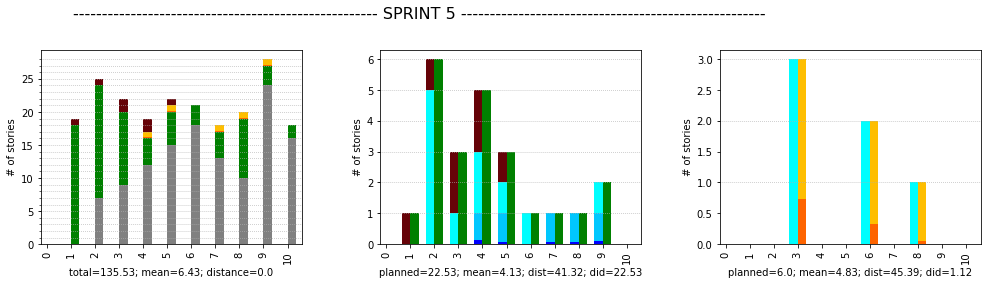

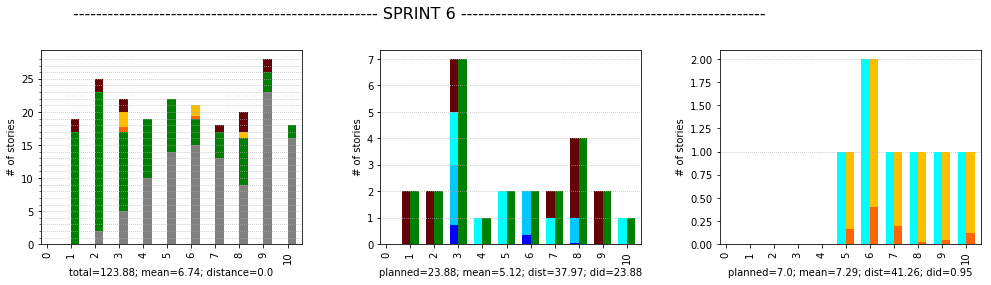

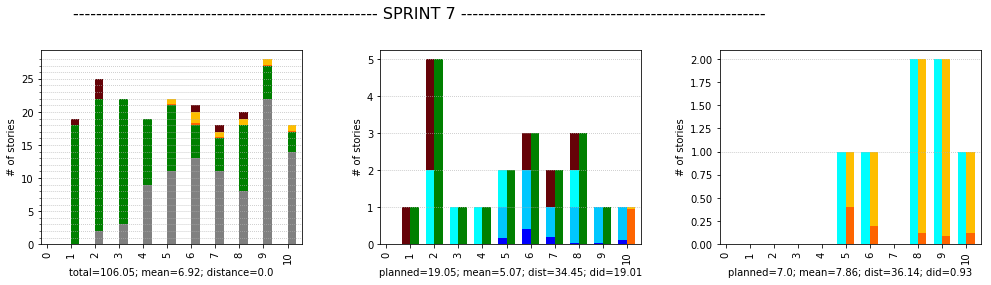

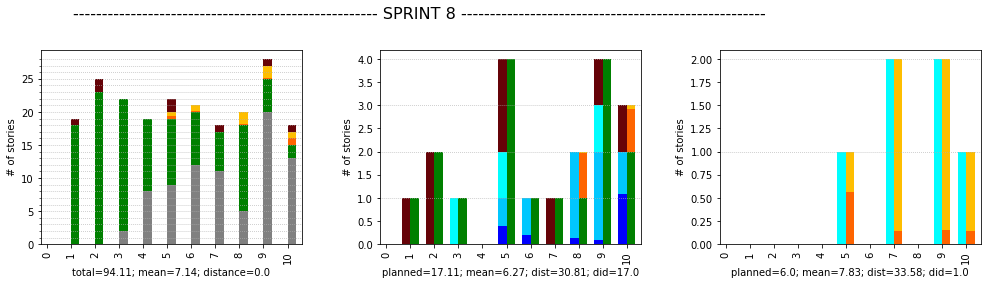

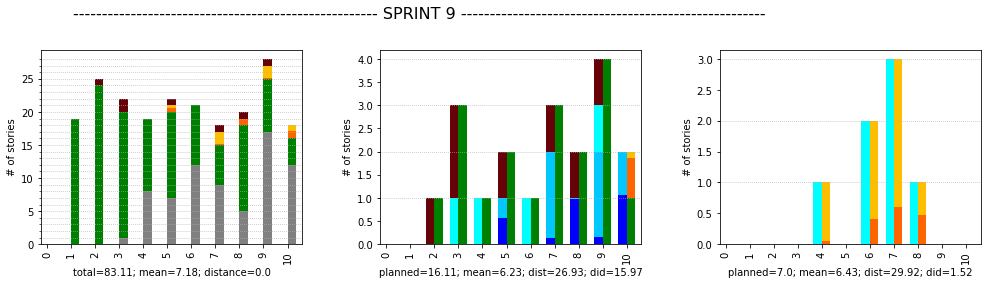

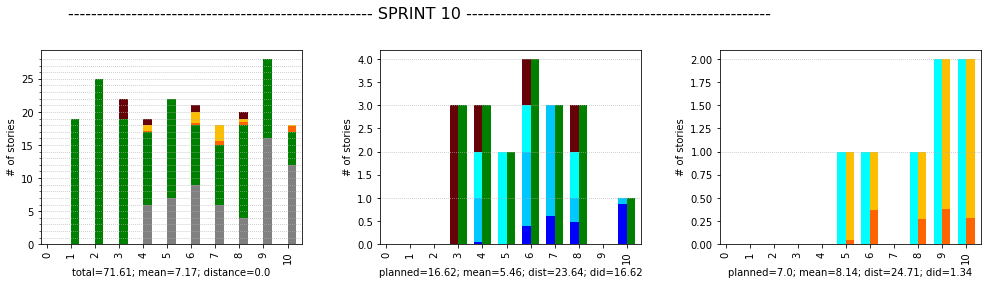

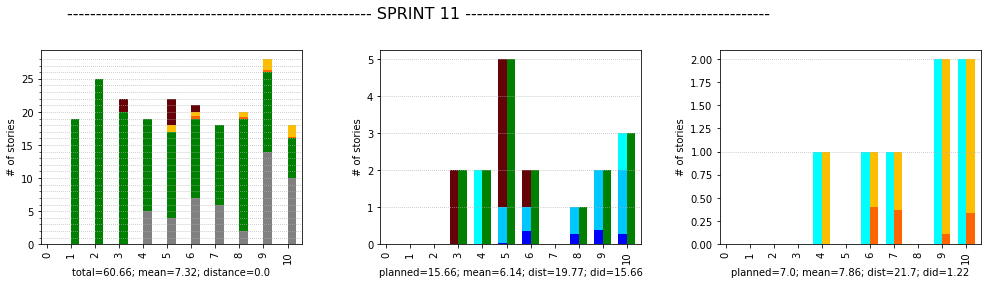

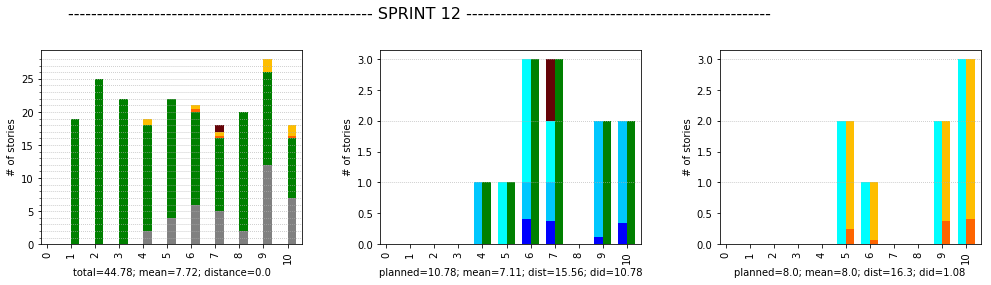

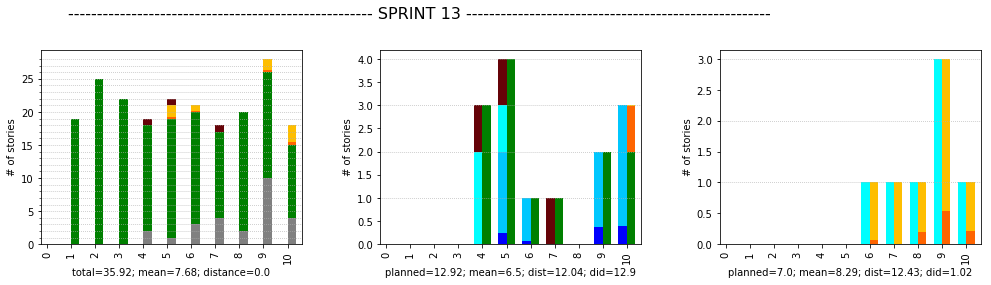

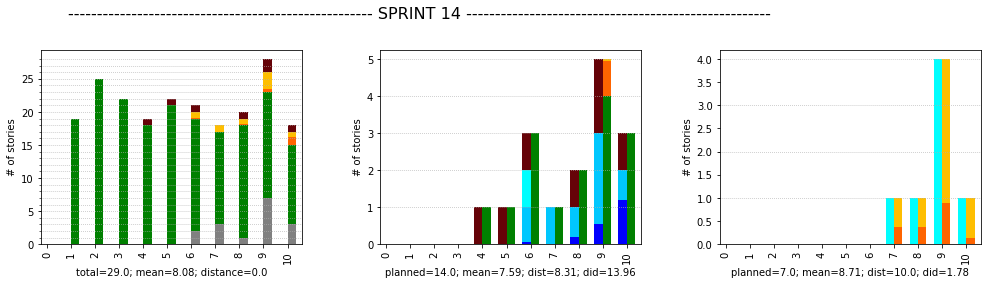

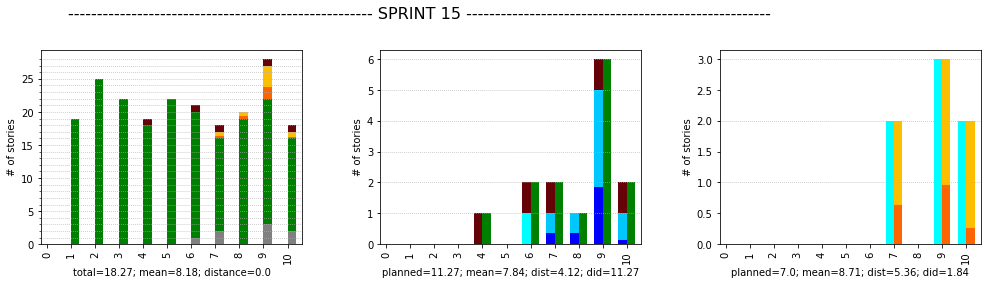

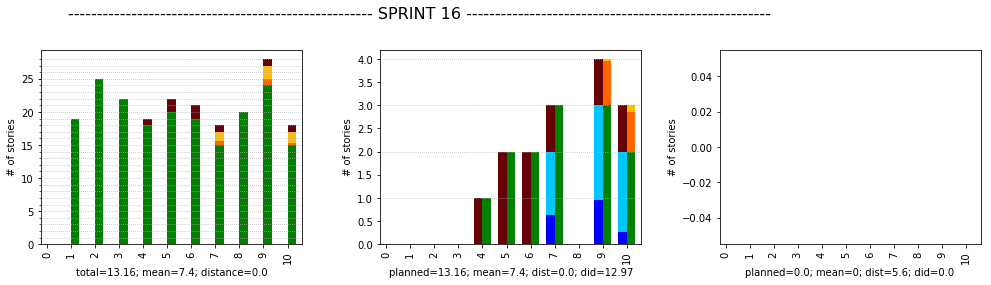

In [21]:
tc_visuals.renderReleaseCycleLog('Team A', releaseLog, 1, 16)

In [22]:
stories_df = build_stories_df(modelsConfig)
stories_df[:6]

,User Story Id,Original Estimate,Team Id,Developer,Product Manager,Percent Achieved,Planned,Sprint Planned,Sprint Delivered,Nb Open Bugs,Open Bugs,Nb Closed Bugs,Closed Bugs
0,UserStory #1,10,Team A,Bruno Studley,Sherlyn Cordle,1.0,True,11,12,0,[],1,[Ticket #300]
1,UserStory #2,10,Team A,Beau Hockensmith,Sherlyn Cordle,1.0,True,10,11,0,[],0,[]
2,UserStory #3,4,Team A,Anton Easterday,Edgar Hibbler,1.0,True,4,5,0,[],0,[]
3,UserStory #4,7,Team A,Anton Easterday,Sherlyn Cordle,1.0,True,9,10,0,[],0,[]
4,UserStory #5,3,Team A,Glenna Mcghie,Edgar Hibbler,1.0,True,8,8,0,[],1,[Ticket #208]
5,UserStory #6,3,Team A,Anton Easterday,Sherlyn Cordle,1.0,True,2,2,0,[],1,[Ticket #29]


In [23]:
stories_df[stories_df['Nb Closed Bugs'] > 2]

,User Story Id,Original Estimate,Team Id,Developer,Product Manager,Percent Achieved,Planned,Sprint Planned,Sprint Delivered,Nb Open Bugs,Open Bugs,Nb Closed Bugs,Closed Bugs
402,UserStory #403,9,Team C,Milan Hinman,Jamie Addington,1.0,True,6,6,0,[],3,"[Ticket #134, Ticket #164, Ticket #193]"
517,UserStory #518,1,Team C,Marquis Tefft,Jamie Addington,1.0,True,3,3,0,[],3,"[Ticket #48, Ticket #84, Ticket #115]"
586,UserStory #587,4,Team D,Olevia Haymaker,Georgine Roan,1.0,True,3,3,0,[],3,"[Ticket #51, Ticket #88, Ticket #118]"
776,UserStory #777,6,Team D,Pedro Sisk,Georgine Roan,1.0,True,12,12,0,[],3,"[Ticket #299, Ticket #317, Ticket #342]"


In [24]:
bugs = modelsConfig.context.ticketsRepo.getClosedTickets('UserStory #777')
bugs_df = build_bugs_df(bugs)
bugs_df

,Ticket Id,User Story Id,Estimated Cost,Effort to Date,Percent Achieved,Sprint Reported,Sprint Fixed
0,Ticket #299,UserStory #777,1.2,1.2,1.0,13,14
1,Ticket #317,UserStory #777,1.2,1.2,1.0,14,15
2,Ticket #342,UserStory #777,1.2,1.2,1.0,15,16


In [25]:
entries_df[entries_df['User Story'] == 'UserStory #106']

,Sprint,Date,Team,Developer,User Story,Task Type,Task Description,Time Spent
0,1,2018-01-29,Team A,Anton Easterday,UserStory #106,UNFINISHED_STORIES,Story implementation,7.0
150,3,2018-02-26,Team A,Anton Easterday,UserStory #106,DEV_TIME_BUGS,Ticket #1,1.4


In [27]:
df = releaseLog.log['Team A'][9]['Outcome']
df

,Owner,Task Type,Task Description,User Story Id,Planned for Sprint,Delivered in Sprint,Original Estimate,Bucket,Effort Spent,Effort Remaining,Percent Achieved
0,Anton Easterday,UNFINISHED_STORIES,Story implementation,UserStory #184,8,9,2.2,CURRENT_SPRINT,2.2,0.0,1.000000
1,Anton Easterday,UNFINISHED_STORIES,Story implementation,UserStory #124,9,9,4.0,CURRENT_SPRINT,4.0,0.0,1.000000
2,Anton Easterday,UNFINISHED_STORIES,Story implementation,UserStory #11,9,9,3.0,CURRENT_SPRINT,3.0,0.0,1.000000
3,Anton Easterday,UNFINISHED_STORIES,Story implementation,UserStory #4,9,NOT_SET,7.0,NEXT_SPRINT,0.8,6.2,0.114286
4,Beau Hockensmith,DEV_TIME_BUGS,Ticket #151,UserStory #24,9,9,0.6,CURRENT_SPRINT,0.6,0.0,1.000000
5,Beau Hockensmith,DEV_TIME_BUGS,Ticket #152,UserStory #45,9,9,1.6,CURRENT_SPRINT,1.6,0.0,1.000000
6,Beau Hockensmith,DEV_TIME_BUGS,Ticket #153,UserStory #80,9,9,0.6,CURRENT_SPRINT,0.6,0.0,1.000000
7,Beau Hockensmith,UNFINISHED_STORIES,Story implementation,UserStory #162,8,NOT_SET,8.6,CURRENT_SPRINT,7.2,1.4,0.837209
8,Bruno Studley,UNFINISHED_STORIES,Story implementation,UserStory #196,7,9,0.8,CURRENT_SPRINT,0.8,0.0,1.000000
9,Bruno Studley,UNFINISHED_STORIES,Story implementation,UserStory #65,9,9,9.0,CURRENT_SPRINT,9.0,0.0,1.000000


In [ ]:
dfe = releaseLog.log['Team A'][3]['planned_End_CURRENT_SPRINT']
dfe

In [ ]:
dfs = releaseLog.log['Team A'][3]['planned_Start_CURRENT_SPRINT']
dfs

In [ ]:
dfbl = releaseLog.log['Team A'][3]['backlog']
dfbl

In [ ]:
bugs_df = build_bugs_df(modelsConfig.context.ticketsRepo.tickets)
c1 = bugs_df['Sprint Reported'] < 4
c2 = bugs_df['Sprint Fixed'] > 2
b3 = bugs_df[c1]# & c2]
b3

In [ ]:
b3['User Story Id'].unique()

In [ ]:
b3.shape

In [ ]:
bugs_df.groupby('User Story Id').count()

In [ ]:
df = releaseLog.log['Team B'][6]['Outcome']
df[df['User Story Id'] == 'UserStory #120']

In [ ]:
bugs_df[bugs_df['User Story Id']=='UserStory #120']

In [ ]:
entries_df[entries_df['User Story'] == 'UserStory #120']

<h2>Burnout in release cycle - Pilot</h2>

In [ ]:
# 
def genReleaseCycle(modelsConfig):
    RELEASE_DURATION = 60
    SPRINT_DURATION = 10
    
    tu_.loadTestResources()
    
    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, \
                                                                                           tu_.PM_DF, \
                                                                                           RELEASE_DURATION, \
                                                                                           SPRINT_DURATION, \
                                                                                          modelsConfig)
    
    NUMBER_OF_SPRINTS = 25

    entries_df, worksheets = timecard.runReleaseCycle(teamsRepo, ticketsRepo, storiesRepo, datetime(2018, 1, 15), \
                                                   SPRINT_DURATION, NUMBER_OF_SPRINTS, modelsConfig)    
    
    return entries_df, worksheets, storiesRepo

In [ ]:
def genBurnout(entries_df, storiesRepo):
    bystory = entries_df.groupby('User Story')
    u = bystory.apply(storyInfo, storiesRepo)
    
    
    u = u.reset_index()
    u.drop(['level_1'], axis='columns', inplace=True)
    s = u.groupby('Final Sprint')
    burnout = s.apply(sprintInfo)
    burnout = burnout.reset_index()
    burnout.drop(['level_1'], axis='columns', inplace=True)
    

    return burnout, u

In [ ]:
def storyInfo(group_df, storiesRepo):
    info = {}
    
    #Go back, as min['Date'] is end of first sprint
    info['Start'] = [timecard.subtractBusinessDays(group_df['Date'].min(), SPRINT_DURATION)] 
    info['End'] = [group_df['Date'].max()]
    info['Elapsed Time'] = (info['End'][0] - info['Start'][0]).days
    info['Effort'] = group_df['Time Spent'].sum()
    info['Initial Sprint'] = [group_df['Sprint'].min()]
    info['Final Sprint'] = [group_df['Sprint'].max()]  
    '''
    userStoryId = group_df['User Story']
    userStory = storiesRepo.findStory(userStoryId)
    info['Original estimate'] = userStory.originalEstimate    
    '''
    
    return pd.DataFrame(info)

In [ ]:
def sprintInfo(group_df):
    info = {}
    
    info['Effort'] = group_df['Effort'].sum()
    info['Avg Effort'] = group_df['Effort'].mean()
    info['Stories Completed'] = [group_df['User Story'].count()]
    info['Over 1 sprint'] = [group_df[group_df['Elapsed Time']==14]['User Story'].count()]
    info['Over 2 sprint'] = [group_df[group_df['Elapsed Time']==28]['User Story'].count()]
    info['Over 3 sprint'] = [group_df[group_df['Elapsed Time']==42]['User Story'].count()]
    info['Over 4 sprint'] = [group_df[group_df['Elapsed Time']==56]['User Story'].count()]
 
    
    return pd.DataFrame(info)

In [ ]:
SPRINT_DURATION = 10
modelsConfig1 = ModelsConfig([DefaultCostModel(0.0)], [], BalancedAllocationModel(SPRINT_DURATION)) 
modelsConfig1.random.reset(271)
entries_df1, worksheets1, storiesRepo = genReleaseCycle(modelsConfig1)

In [ ]:
burn1, u1 = genBurnout(entries_df1, storiesRepo)
burn1

In [ ]:
u1

In [ ]:
SPRINT_DURATION = 10
modelsConfig2 = ModelsConfig([DefaultCostModel(0.0)], [], GreedyAllocationModel(SPRINT_DURATION)) 
modelsConfig2.random.reset(271)
entries_df2, worksheets2, storiesRepo = genReleaseCycle(modelsConfig2)

In [ ]:
burn2, u2 = genBurnout(entries_df2, storiesRepo)
burn2

In [ ]:
burn1['Effort'].plot(label = 'Balanced'), burn2['Effort'].plot(label = 'Greedy'), plt.legend()

In [ ]:
burn1['Avg Effort'].plot(label = 'Balanced'), burn2['Avg Effort'].plot(label = 'Greedy'), plt.legend()

In [ ]:
u1_10 = u1[u1['Final Sprint'] == 10]
u1_10.shape

In [ ]:
u1_10[u1_10['Initial Sprint'] == 10]['Effort'].mean()

In [ ]:
u1_10['Effort'].mean()

In [ ]:
u1_10[u1_10['Initial Sprint'] == 10].shape

In [ ]:
u1_10[u1_10['Initial Sprint'] == 9]['Effort'].mean()

In [ ]:
u1_10[u1_10['Initial Sprint'] == 9].shape